# Face recognition using ANN with sigmoid/softmax

* We will focus on class 0 and 1
* 4953 samples of class 0, 547 samples of class 1

### Class Imbalance
* We will implement a binary classifier using logistic Regression. Therefore, we will focus on class 0 and 1.
* There are 4953 samples of class 0 and 547 samples of class 1.
* What would my classifiction rate be if I just choose 0 every time.
    * (4953 - 547) / 4953, therefore imbalance classification problem

### 2-class problem vs. 7-class problem 
* When we swich to softmax, will the problem get easier or harder?
    * 2-class: guess at random - expect 50% error
    * 7-class: guess at random - expect 6/7 = 86% error
    * K class: 1/K chance of being correct
* Kaggle top score" ~70% correct"

    
### Solving class imbalance
* Suppose we have 1000 samples from class 1, 100 samples from class 2
    * Method 1) Pick 100 samples from class 1, now we have 100 vs. 100
    * Method 2) Repeat class 2 10 times, now we have 1000 vs. 1000
    * Same 'expected' error rate
    * But method 2 is better (less variance, more data)
* Other options to expand class 2:
    * Add Gaussian noise
    * Add invariant transformatoins (shift left, right rotate, etc.)
    

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [17]:
def getBinaryData(balance_ones=False):
    # images are 48x48=2304 size vectors
    # N=5500
    Y=[]
    X=[]
    first=True
    for line in open('data/fer2013/fer2013.csv'):
        if first:
            first=False
        else:
            row=line.split(',')
            y = int(row[0])
            if y == 0 or y == 1:
                Y.append(y)
                X.append([int(p) for p in row[1].split()])
    X, Y = np.array(X)/255.0, np.array(Y)  
    
#     if balance_ones:
#         X0, Y0 = X[Y==0, :], Y[Y==0]
#         X1 = X[Y==1, :]
#         X1 = np.repeat(X1, 9, axis=0)
#         X = np.vstack([X0, X1])
#         Y = np.concatenate((Y0, [1]*len(X1)))
    return X, Y

In [20]:
X, Y = getBinaryData(balance_ones=False)
print(X.shape)

(5500, 2304)


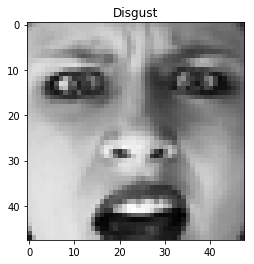

In [30]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

X, Y = getBinaryData()

i = np.random.choice(2)
x, y = X[Y==i], Y[Y==i]
N = len(y)
j = np.random.choice(N)
plt.imshow(x[j].reshape(48, 48), cmap='gray')
plt.title(label_map[y[j]])
plt.show()

In [150]:

def relu(A):
    return A * (A > 0)

def sigmoid(A):
    return 1 / (1 + np.exp(-A))

def sigmoid_cross_entropy(T, Y):
    return -(T * np.log(Y) + (1 - T) * np.log(1 - Y)).sum()
    
def softmax_cross_entropy(T, Y):
    return -(T * np.log(Y)).mean()
    
def error_rate(T, P):
    return np.mean(T != P)

def init_weight_and_bias(M1, M2):
    W = np.random.randn(M1, M2) / np.sqrt(M1 + M2) # why M1 + M2
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(nbp.float32)

## ANN with sigmoid

In [75]:
class ANN(object):
    def __init__(self, M):
        self.M = M
        
    def fit(self, X, Y, learning_rate=5*10e-7, reg=1.0, epochs=10000, show_fig=False):
        
        X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]
        
        N, D = X.shape
        
        self.W1 = np.random.randn(D, self.M) / np.sqrt(D + self.M)
        self.b1 = np.zeros(self.M)
        self.W2 = np.random.randn(self.M) / np.sqrt(self.M)
        self.b2 = 0
        
        costs = []
        best_validation_error = 1
        for ep in range(epochs):
            
            # forward propagation
            Py, Z = self.forward(X)
            
            """
             gradient descent via back propagation 
             Here we update the weights for two layers (the hidden layer and the outer layer).
             Actually, the forward propagation involves similar computation for the two layers 
             (check the forward method for detail). We can encapsulate the forward 
             propragation and back propragation in a HiddenLayer class by following OOD principles.
            """    
            Py_Y = Py - Y
            self.W2 -= learning_rate * (Z.T.dot(Py_Y) + reg * self.W2)
            self.b2 -= learning_rate * (Py_Y.sum() + reg * self.b2)
            
            # dZ = (Py_Y).dot(W2.T) * (Z > 0)
#             dZ = np.outer(Py_Y, self.W2) * (Z > 0)
#             dZ = np.outer(Py_Y, self.W2) * (1 - Z * Z)
            dZ = np.outer(Py_Y, self.W2) * Z * (1 - Z)
            self.W1 -= learning_rate * (X.T.dot(dZ) + reg * self.W1)
            self.b1 -= learning_rate * (np.sum(dZ, axis=0) + reg * self.b1)
                
            # show performace metrics
            if ep % 20 == 0:
                Pyvalid, _ = self.forward(Xvalid)
                cost = sigmoid_cross_entropy(Yvalid, Pyvalid)
                costs.append(cost)
                e = error_rate(Yvalid, np.round(Pyvalid))
                print("ep:", ep, "cost:", cost, "error:", e)
                if e < best_validation_error:
                    best_validation_error = e
        print("best_validation_error:", best_validation_error)              

        if show_fig:
            plt.plot(costs)
            plt.show()
        
                                        
    def forward(self, X):
        Z = sigmoid(X.dot(self.W1) + self.b1)
        Py = sigmoid(Z.dot(self.W2) + self.b2)
        return Py, Z
                               
    def predict(self, X):
        Py, _ = self.forward(Xvalid)
        return np.round(Py)
                               
    def score(self, X, Y):
        predictions = self.predict(X)
        return 1 - error_rate(Y, predictions)
                               
            

In [42]:
X, Y = getBinaryData()

X0, X1 = X[Y==0, :], X[Y==1,:]
X1 = np.repeat(X1, 9, axis=0)
X = np.vstack([X0, X1])
Y = np.array([0]*len(X0) + [1]*len(X1))
print(X.shape)
print(Y.shape)

(49260, 2304)
(49260,)


In [76]:
model = ANN(100)
model.fit(X, Y, epochs=10000, show_fig=True)


ep: 0 cost: 648.287427205 error: 0.099
ep: 20 cost: 315.364918933 error: 0.099
ep: 40 cost: 314.544985785 error: 0.099
ep: 60 cost: 313.694409902 error: 0.099
ep: 80 cost: 312.796499214 error: 0.099
ep: 100 cost: 311.838809149 error: 0.098
ep: 120 cost: 310.810691023 error: 0.098
ep: 140 cost: 309.703675634 error: 0.098
ep: 160 cost: 308.512932861 error: 0.098
ep: 180 cost: 307.235831863 error: 0.098
ep: 200 cost: 305.870666579 error: 0.098
ep: 220 cost: 304.419640848 error: 0.098
ep: 240 cost: 302.890781757 error: 0.098
ep: 260 cost: 301.297486502 error: 0.098
ep: 280 cost: 299.657377633 error: 0.098
ep: 300 cost: 297.988104404 error: 0.098
ep: 320 cost: 296.303165207 error: 0.098
ep: 340 cost: 294.613795714 error: 0.098
ep: 360 cost: 292.931142994 error: 0.098
ep: 380 cost: 291.265174443 error: 0.098
ep: 400 cost: 289.623268883 error: 0.098
ep: 420 cost: 288.0099226 error: 0.098
ep: 440 cost: 286.427209496 error: 0.098
ep: 460 cost: 284.875462982 error: 0.097
ep: 480 cost: 283.353439

KeyboardInterrupt: 

## ANN with softmax

In [99]:
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

# one-hot-encoding on labels
def y2Indicator(Y, dims):
    N = len(Y)
    Y = Y.astype(np.int32)
    ind = np.zeros((N, dims))
    for i in range(N):
        ind[i, Y[i]] = 1
    return ind

In [151]:
class ANN_Softmax(object):
    
    def __init__(self, M):
        self.M = M
    
    # learning rate 10e-6 is too large
    def fit(self, X, Y, learning_rate=10e-7, reg=10e-7, epochs=10000, show_fig=False):
        
        print("learning rate: " , learning_rate)
        print("reg: " , reg)
            
        X, Y = shuffle(X, Y)
        N, D = X.shape
        K = len(set(Y))
        
        print("K", K)
        
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        Tvalid = y2Indicator(Yvalid, K)
        X, Y = X[:-1000], Y[:-1000]
        T = y2Indicator(Y, K)

        self.W1 = np.random.randn(D, self.M) / np.sqrt(D + self.M)
        self.b1 = np.zeros(self.M)
        self.W2 = np.random.randn(self.M, K) / np.sqrt(self.M + K)
        self.b2 = np.zeros(K)
        
        costs = []
        best_validation_error = 1
        for ep in range(epochs):
            
            # forward propagation
            Py, Z = self.forward(X)
#             print("Py", Py[1])
#             print("Py sum", Py[1].sum())
#             print("T", T[1])
            # gradient descent via back propagation
            Py_Y = Py - T
            self.W2 -= learning_rate * (Z.T.dot(Py_Y) + reg * self.W2)
            self.b2 -= learning_rate * (Py_Y.sum(axis=0) + reg * self.b2)
            
            dZ = Py_Y.dot(self.W2.T) * (1 - Z * Z)
            self.W1 -= learning_rate * (X.T.dot(dZ) + reg * self.W1)
            self.b1 -= learning_rate * (dZ.sum(axis=0) + reg * self.b1)
                
            # show performance metrics
            if ep % 10 == 0:
                Pyvalid, _ = self.forward(Xvalid)
                c = softmax_cross_entropy(Tvalid, Pyvalid)
                costs.append(c)
                e = error_rate(Yvalid, np.argmax(Pyvalid, axis=1))
                print("ep:", ep, "cost:", c, "error:", e)
                if e < best_validation_error:
                    best_validation_error = e
        print("best_validation_error:", best_validation_error)              

        if show_fig:
            plt.plot(costs)
            plt.show()  
            
    def forward(self, X):
        Z = np.tanh(X.dot(self.W1) + self.b1)
        return softmax(Z.dot(self.W2) + self.b2), Z


In [147]:
def get_data(balance_ones=False):
    # images are 48x48=2304 size vectors
    # N=5500
    Y=[]
    X=[]
    first=True
    for line in open('data/fer2013/fer2013.csv'):
        if first:
            first=False
        else:
            row=line.split(',')
            y = int(row[0])
            Y.append(y)
            X.append([int(p) for p in row[1].split()])
    X, Y = np.array(X) / 255.0, np.array(Y)  
    return X, Y

In [148]:
X, Y = get_data()

XO, YO = X[Y!=1, :], Y[Y!=1]
X1 = X[Y==1, :]
X1 = np.repeat(X1, 9, axis=0)
X = np.vstack([XO, X1])
Y = np.concatenate((YO, [1]*len(X1)))
print(X.shape)
print(Y.shape)

(40263, 2304)
(40263,)


<class '__main__.ANN_Softmax'>
learning rate:  1e-06
reg:  1e-06
K 7
ep: 0 cost: 0.288875164995 error: 0.761
ep: 10 cost: 0.273316947829 error: 0.823
ep: 20 cost: 0.267978322311 error: 0.735
ep: 30 cost: 0.266051507312 error: 0.726
ep: 40 cost: 0.267395608051 error: 0.743
ep: 50 cost: 0.264540573644 error: 0.71
ep: 60 cost: 0.263825798905 error: 0.695
ep: 70 cost: 0.264401330615 error: 0.725
ep: 80 cost: 0.262639223364 error: 0.694
ep: 90 cost: 0.262653754574 error: 0.721
ep: 100 cost: 0.261474876543 error: 0.695
ep: 110 cost: 0.26216228989 error: 0.698
ep: 120 cost: 0.260744306253 error: 0.702
ep: 130 cost: 0.259425848991 error: 0.685
ep: 140 cost: 0.261573410933 error: 0.697
ep: 150 cost: 0.260081839926 error: 0.695
ep: 160 cost: 0.257629090275 error: 0.676
ep: 170 cost: 0.26023281223 error: 0.708
ep: 180 cost: 0.26332379476 error: 0.733
ep: 190 cost: 0.256973559263 error: 0.668
ep: 200 cost: 0.257213328253 error: 0.681
ep: 210 cost: 0.258634546791 error: 0.701
ep: 220 cost: 0.256021

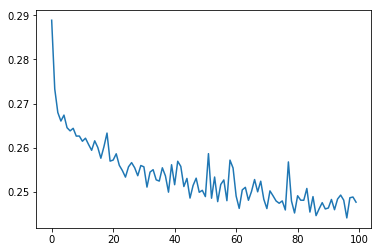

In [152]:
model = ANN_Softmax(100)
print(type(model))
model.fit(X, Y, epochs=1000, show_fig=True)


## Mini Quizzes

### Gradient descent for binary classification
* Suppose that instead of doing multi-class classification we do binary classification
    * One output node and sigmoid instead of softmax
* What does gradient look like?
* Aussume 1-hidden-layer neural network
* Input-to-hidden weights called W, hidden-to-output weights called V
* No bias terms

### Gradient descent for regression

* Regression instead of classification
* Only the last layer changes
* Neural network for binary classification is just a bunch of nonlinear layers with logistic regression at the end
    * Input -> Hidden Layer -> Hidden Layer -> ... -> Logistic Regression
* To do regression, we keep all the nonlinear layers, and do linear regression at the end instead
    * Input -> Hidden Layer -> Hidden Layer -> ... -> Linear Regression
* Now the output can take on any value
* You must use the correct cost function (hint: it is not cross-entropy)
* Same setup: W, V, no bias terms



### Final note
* While the update equations are the same, that does not mean binary classification is the same as regression
* The y's and t's represent different things and take on different values